## LSTM AutoEncoders :

References : <br>  https://github.com/VivekPa/AIAlpha  <br>  https://medium.com/analytics-vidhya/using-machine-learning-to-predict-stock-prices-c4d0b23b029a  <br>  https://github.com/borisbanushev/stockpredictionai#thedata  <br>  https://github.com/borisbanushev/stockpredictionai  <br>  https://towardsdatascience.com/aifortrading-2edd6fac689d  <br>  https://pywavelets.readthedocs.io/en/latest/ref/dwt-discrete-wavelet-transform.html  <br>  https://github.com/zhiruiwang/LSTM_stock_price_prediction/blob/master/code.ipynb  <br>  https://github.com/amunategui/CVAE-Financial-Anomaly-Detection/blob/master/Financial%20Compliance%20and%20Fraud%20Detection%20with%20Conditional%20Variational%20Autoencoders%20(CVAE)%20and%20Tensorflow.ipynb  <br>  https://amunategui.github.io/cvae-in-finance/index.html  <br>  https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0180944

## Import Data from Yahoo Finance fr Apple Inc.

Here we will download the financial data for Apple Inc. Stock Prices for the Duration of 1st January 2013 to 1st December 2018 from Yahoo Finance Stock Data and convert it into a pandas DataFrame for furhter analysis using LSTM Autoencoders.

In [1]:
import pandas_datareader.data as pdr
import fix_yahoo_finance as fix
fix.pdr_override()


class GetData:
    def __init__(self, ticker, start, end):
        self.ticker = ticker
        self.start = start
        self.end = end

    # get stock data
    def get_stock_data(self):
        stock_data_GOOGL = pdr.get_data_yahoo(self.ticker, self.start, self.end)
        stock_data_GOOGL.to_csv("stock_data_GOOGL.csv")

if __name__ == "__main__":
    data = GetData("GOOGL", "2013-01-01", "2018-12-01")
data.get_stock_data()

[*********************100%***********************]  1 of 1 downloaded


Here we will use a date parser function for converting timestamps into dates for ease of use in the code.

In [2]:
def parser(x):
    return datetime.datetime.strptime(x,'%Y-%m-%d')

## Import Libraries and Packages

In [3]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Import pandas .csv file and display its head

In [4]:
stock_data_GOOGL = pd.read_csv('stock_data_GOOGL.csv', header=0, parse_dates=[0], date_parser=parser)
stock_data_GOOGL.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,360.07,363.86,358.63,361.99,361.99,5077500
1,2013-01-03,362.83,366.33,360.72,362.20,362.20,4631700
2,2013-01-04,365.04,371.11,364.20,369.35,369.35,5521400
3,2013-01-07,368.09,370.06,365.66,367.74,367.74,3308000
4,2013-01-08,368.14,368.52,362.58,367.02,367.02,3348800


## Plot the Stock Market Graph for Apple Inc. for given duration

C:\Users\NEERAJ\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


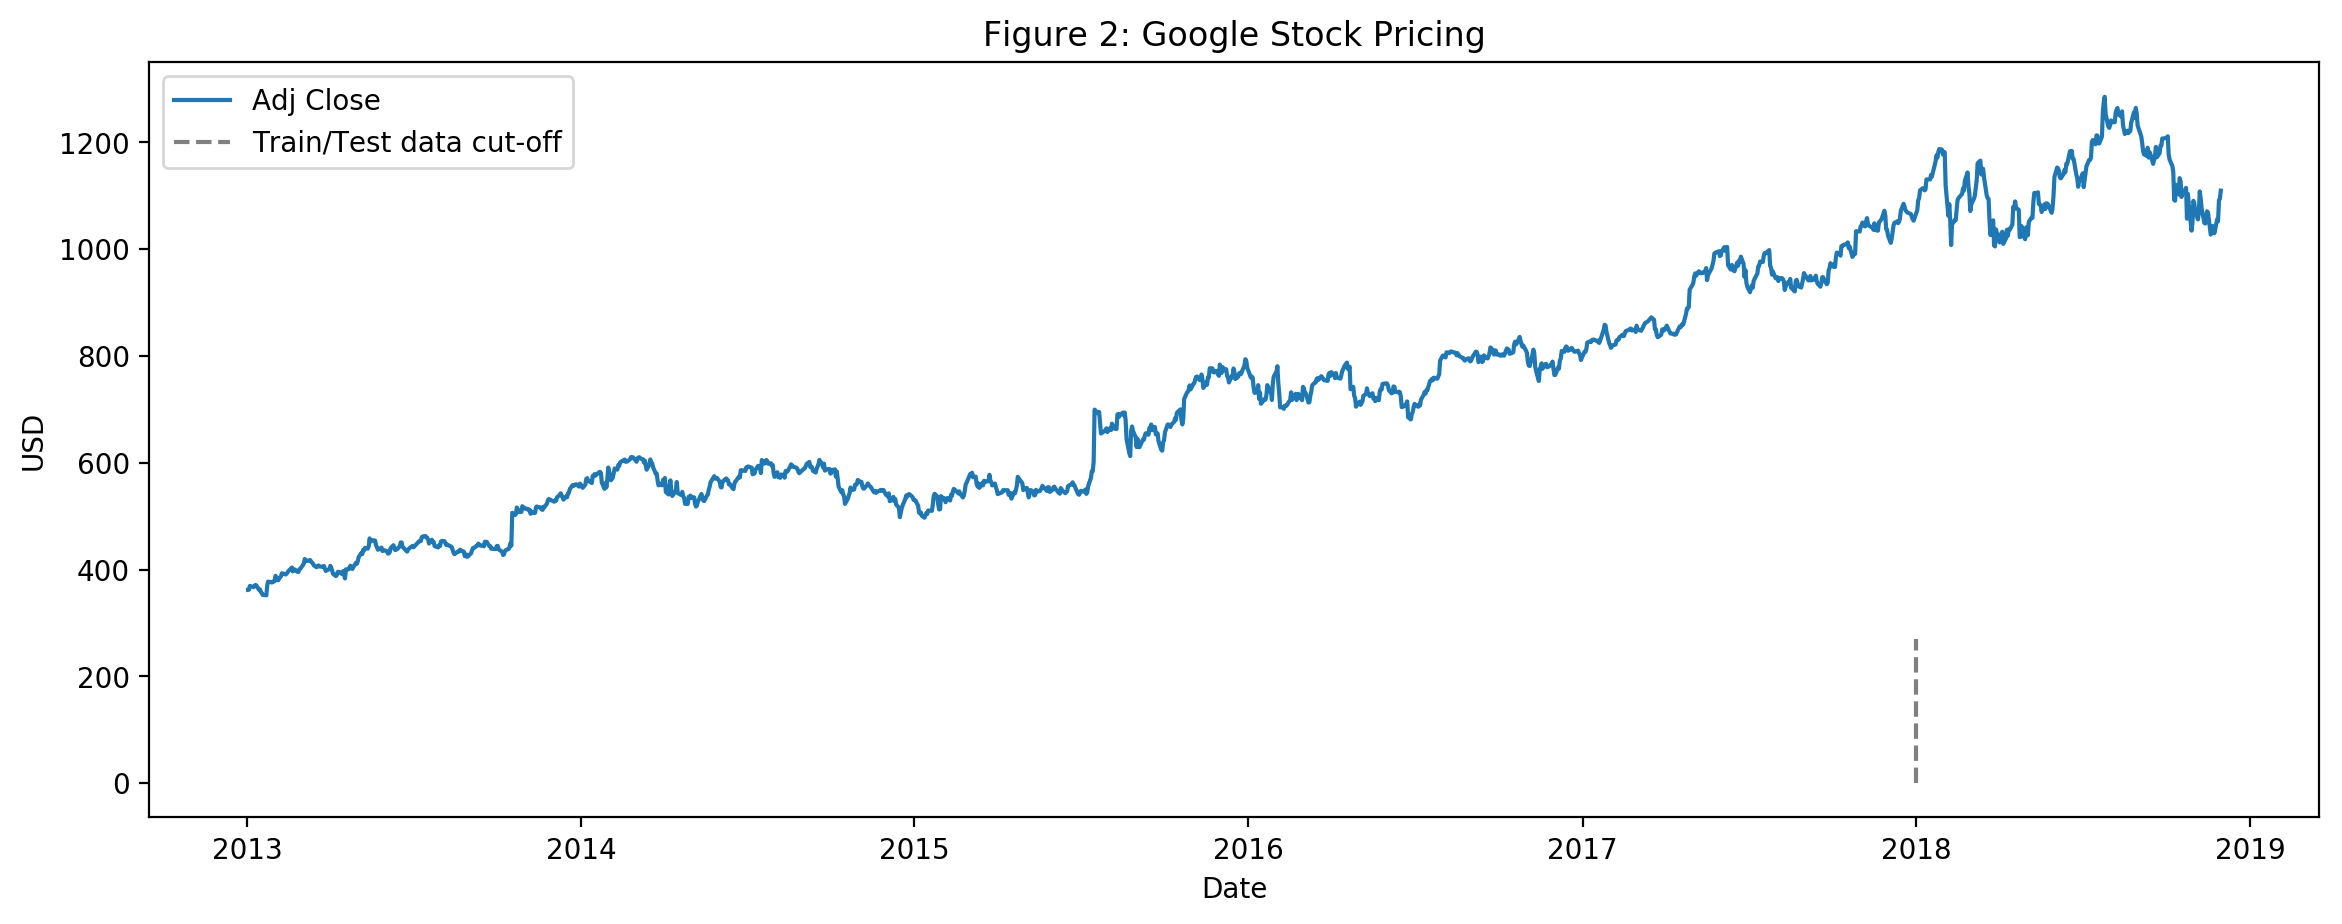

In [5]:
plt.figure(figsize=(14, 5), dpi=200)
plt.plot(stock_data_GOOGL['Date'], stock_data_GOOGL['Adj Close'])
plt.vlines(datetime.date(2018,1, 1), 0, 270, linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Figure 2: Google Stock Pricing')
plt.legend()
plt.show()

## Analyze the number of days and split training and testing days

In [6]:
num_training_days = int(stock_data_GOOGL.shape[0]*.7)
print('Number of training days: {}. Number of test days: {}.'.format(num_training_days, \
                                                                    stock_data_GOOGL.shape[0]-num_training_days))

Number of training days: 1043. Number of test days: 448.


## Analyze the Data using Fourier Transforms

In [7]:
data_FT = stock_data_GOOGL[['Date', 'Adj Close']]

In [8]:
close_fft = np.fft.fft(np.asarray(data_FT['Adj Close'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

## Plot the Graph for Fourier Transforms

C:\Users\NEERAJ\Anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


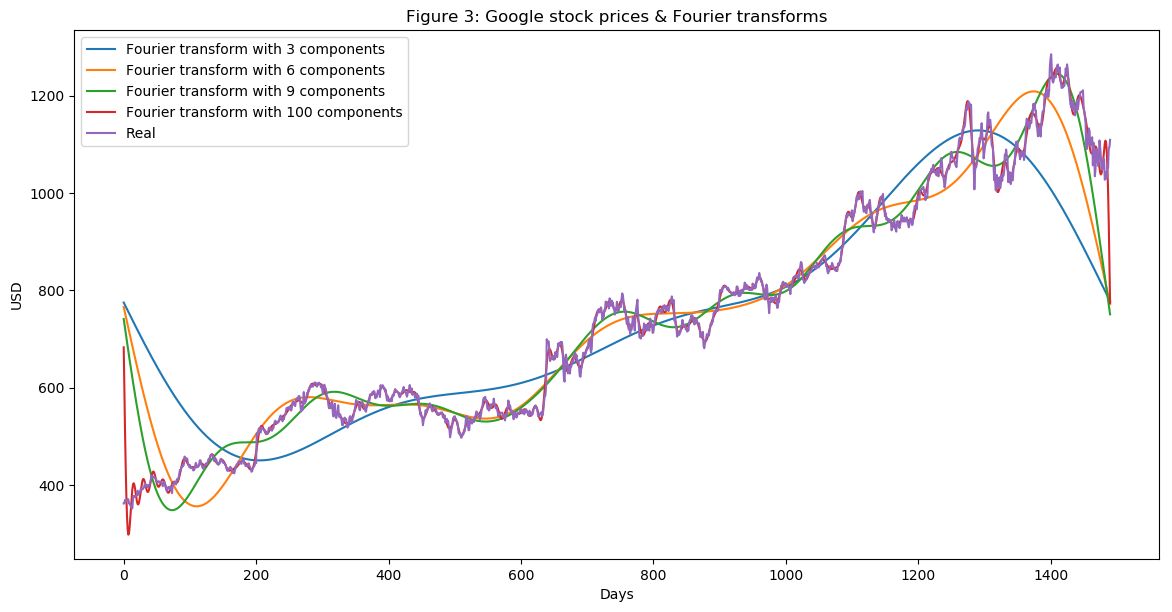

In [9]:
plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [3, 6, 9, 100]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.plot(data_FT['Adj Close'],  label='Real')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 3: Google stock prices & Fourier transforms')
plt.legend()
plt.show()

## Plot the Components in the Fourier Transforms

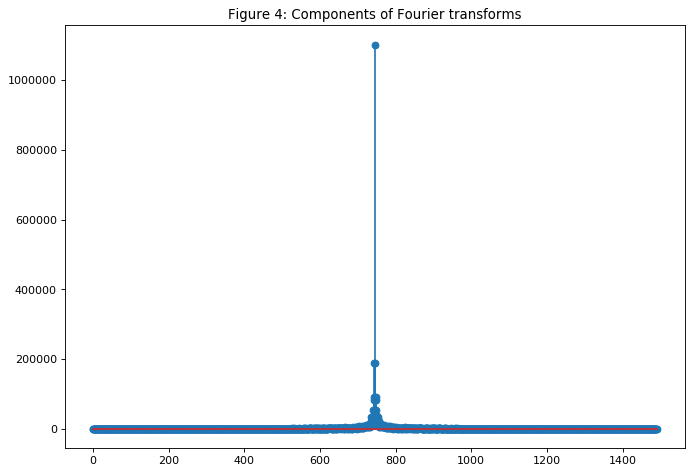

In [10]:
from collections import deque
items = deque(np.asarray(fft_df['absolute'].tolist()))
items.rotate(int(np.floor(len(fft_df)/2)))
plt.figure(figsize=(10, 7), dpi=80)
plt.stem(items)
plt.title('Figure 4: Components of Fourier transforms')
plt.show()

## Pre-process the Data and Wavelet Transforms

Here we will pre-process the data by splitting into traning and testing data and apply Wavelet Transforms to them for de-noising and preserving the time essence

In [11]:
import numpy as np
import pandas as pd
import pywt
import matplotlib.pyplot as plt


class PreProcessing:
    def __init__(self, split, feature_split):
        self.split = split
        self.feature_split = feature_split
        self.stock_data = pd.read_csv("stock_data_GOOGL.csv")

    # wavelet transform and create autoencoder data
    def make_wavelet_train(self):
        train_data = []
        test_data = []
        log_train_data = []
        for i in range((len(self.stock_data)//10)*10 - 11):
            train = []
            log_ret = []
            for j in range(1, 6):
                x = np.array(self.stock_data.iloc[i: i + 11, j])
                (ca, cd) = pywt.dwt(x, "haar")
                cat = pywt.threshold(ca, np.std(ca), mode="soft")
                cdt = pywt.threshold(cd, np.std(cd), mode="soft")
                tx = pywt.idwt(cat, cdt, "haar")
                log = np.diff(np.log(tx))*100
                macd = np.mean(x[5:]) - np.mean(x)
                # ma = np.mean(x)
                sd = np.std(x)
                log_ret = np.append(log_ret, log)
                x_tech = np.append(macd*10, sd)
                train = np.append(train, x_tech)
            train_data.append(train)
            log_train_data.append(log_ret)
        trained = pd.DataFrame(train_data)
        trained.to_csv("preprocessing/indicators_GOOGL.csv")
        log_train = pd.DataFrame(log_train_data, index=None)
        log_train.to_csv("preprocessing/log_train_GOOGL.csv")
        # auto_train = pd.DataFrame(train_data[0:800])
        # auto_test = pd.DataFrame(train_data[801:1000])
        # auto_train.to_csv("auto_train.csv")
        # auto_test.to_csv("auto_test.csv")
        rbm_train = pd.DataFrame(log_train_data[0:int(self.split*self.feature_split*len(log_train_data))], index=None)
        rbm_train.to_csv("preprocessing/rbm_train_GOOGL.csv")
        rbm_test = pd.DataFrame(log_train_data[int(self.split*self.feature_split*len(log_train_data))+1:
                                               int(self.feature_split*len(log_train_data))])
        rbm_test.to_csv("preprocessing/rbm_test_GOOGL.csv")
        for i in range((len(self.stock_data) // 10) * 10 - 11):
            y = 100*np.log(self.stock_data.iloc[i + 11, 5] / self.stock_data.iloc[i + 10, 5])
            test_data.append(y)
        test = pd.DataFrame(test_data)
        test.to_csv("preprocessing/test_data_GOOGL.csv")

    def make_test_data(self):
        test_stock = []
        # stock_data_test = pd.read_csv("stock_data_test.csv", index_col=0)

        for i in range((len(self.stock_data) // 10) * 10 - 11):
            l = self.stock_data.iloc[i+11, 5]
            test_stock.append(l)
            test = pd.DataFrame(test_stock)
            test.to_csv("preprocessing/test_stock_GOOGL.csv")

        stock_test_data = np.array(test_stock)[int(self.feature_split*len(test_stock) +
                                               self.split*(1-self.feature_split)*len(test_stock)):]
        stock = pd.DataFrame(stock_test_data, index=None)
        stock.to_csv("stock_data_test_GOOGL.csv")

        # print(train_data[1:5])
        # print(test_data[1:5])
        # plt.plot(train_data[1])
        # plt.show()


if __name__ == "__main__":
    preprocess = PreProcessing(0.8, 0.25)
    preprocess.make_wavelet_train()
    preprocess.make_test_data()


## Build And Train the Stacked AutoEncoder 

In [12]:
import tensorflow as tf
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
import pandas as pd
import numpy as np


class AutoEncoder:
    def __init__(self, encoding_dim):
        self.encoding_dim = encoding_dim

    def build_train_model(self, input_shape, encoded1_shape, encoded2_shape, decoded1_shape, decoded2_shape):
        input_data = Input(shape=(1, input_shape))

        encoded1 = Dense(encoded1_shape, activation="relu", activity_regularizer=regularizers.l2(0))(input_data)
        encoded2 = Dense(encoded2_shape, activation="relu", activity_regularizer=regularizers.l2(0))(encoded1)
        encoded3 = Dense(self.encoding_dim, activation="relu", activity_regularizer=regularizers.l2(0))(encoded2)
        decoded1 = Dense(decoded1_shape, activation="relu", activity_regularizer=regularizers.l2(0))(encoded3)
        decoded2 = Dense(decoded2_shape, activation="relu", activity_regularizer=regularizers.l2(0))(decoded1)
        decoded = Dense(input_shape, activation="sigmoid", activity_regularizer=regularizers.l2(0))(decoded2)

        autoencoder = Model(inputs=input_data, outputs=decoded)

        encoder = Model(input_data, encoded3)

        # Now train the model using data we already preprocessed
        autoencoder.compile(loss="mean_squared_error", optimizer="adam")

        train = pd.read_csv("preprocessing/rbm_train_GOOGL.csv", index_col=0)
        ntrain = np.array(train)
        train_data = np.reshape(ntrain, (len(ntrain), 1, input_shape))

        # print(train_data)
        # autoencoder.summary()
        autoencoder.fit(train_data, train_data, epochs=1000)

        encoder.save("models/encoder_GOOGL.h5")

        test = pd.read_csv("preprocessing/rbm_test_GOOGL.csv", index_col=0)
        ntest = np.array(test)
        test_data = np.reshape(ntest, (len(ntest), 1, 55))

        print(autoencoder.evaluate(test_data, test_data))
        # pred = np.reshape(ntest[1], (1, 1, 75))
        # print(encoder.predict(pred))

        log_train = pd.read_csv("preprocessing/log_train_GOOGL.csv", index_col=0)
        coded_train = []
        for i in range(len(log_train)):
            data = np.array(log_train.iloc[i, :])
            values = np.reshape(data, (1, 1, 55))
            coded = encoder.predict(values)
            shaped = np.reshape(coded, (20,))
            coded_train.append(shaped)

        train_coded = pd.DataFrame(coded_train)
        train_coded.to_csv("features/autoencoded_data_GOOGL.csv")


if __name__ == "__main__":
    autoencoder = AutoEncoder(20)
autoencoder.build_train_model(55, 40, 30, 30, 40)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/1000
295/295 [==============================] - 5s 17ms/step - loss: 1.2076
Epoch 2/1000
295/295 [==============================] - 0s 91us/step - loss: 1.1958
Epoch 3/1000
295/295 [==============================] - 0s 108us/step - loss: 1.1799
Epoch 4/1000
295/295 [==============================] - 0s 98us/step - loss: 1.1540
Epoch 5/1000
295/295 [==============================] - 0s 98us/step - loss: 1.1153
Epoch 6/1000
295/295 [==============================] - 0s 153us/step - loss: 1.0725
Epoch 7/1000
295/295 [==============================] - 0s 98us/step - loss: 1.0347
Epoch 8/1000
295/295 [==============================] - 0s 101us/step - loss: 1.0032
Epoch 9/1000
295/295 [==============================] - 0s 101us/step - loss: 0.9732
Epoch 10/1000
295/295 [==============================] - 0s 102us/step - loss: 0.9451
Epoch 11/1000
295/295 [===========

295/295 [==============================] - 0s 88us/step - loss: 0.7302
Epoch 91/1000
295/295 [==============================] - 0s 95us/step - loss: 0.7295
Epoch 92/1000
295/295 [==============================] - 0s 98us/step - loss: 0.7291
Epoch 93/1000
295/295 [==============================] - 0s 91us/step - loss: 0.7291
Epoch 94/1000
295/295 [==============================] - 0s 88us/step - loss: 0.7288
Epoch 95/1000
295/295 [==============================] - 0s 91us/step - loss: 0.7281
Epoch 96/1000
295/295 [==============================] - 0s 98us/step - loss: 0.7282
Epoch 97/1000
295/295 [==============================] - 0s 91us/step - loss: 0.7276
Epoch 98/1000
295/295 [==============================] - 0s 95us/step - loss: 0.7266
Epoch 99/1000
295/295 [==============================] - 0s 91us/step - loss: 0.7260
Epoch 100/1000
295/295 [==============================] - 0s 88us/step - loss: 0.7258
Epoch 101/1000
295/295 [==============================] - 0s 91us/step - loss:

295/295 [==============================] - 0s 95us/step - loss: 0.7091
Epoch 186/1000
295/295 [==============================] - 0s 101us/step - loss: 0.7089
Epoch 187/1000
295/295 [==============================] - 0s 102us/step - loss: 0.7090
Epoch 188/1000
295/295 [==============================] - 0s 101us/step - loss: 0.7094
Epoch 189/1000
295/295 [==============================] - 0s 98us/step - loss: 0.7091
Epoch 190/1000
295/295 [==============================] - 0s 95us/step - loss: 0.7088
Epoch 191/1000
295/295 [==============================] - 0s 98us/step - loss: 0.7090
Epoch 192/1000
295/295 [==============================] - 0s 98us/step - loss: 0.7092
Epoch 193/1000
295/295 [==============================] - 0s 98us/step - loss: 0.7094
Epoch 194/1000
295/295 [==============================] - 0s 101us/step - loss: 0.7094
Epoch 195/1000
295/295 [==============================] - 0s 95us/step - loss: 0.7093
Epoch 196/1000
295/295 [==============================] - 0s 95us

295/295 [==============================] - 0s 98us/step - loss: 0.7013
Epoch 281/1000
295/295 [==============================] - 0s 95us/step - loss: 0.7014
Epoch 282/1000
295/295 [==============================] - 0s 98us/step - loss: 0.7020
Epoch 283/1000
295/295 [==============================] - 0s 98us/step - loss: 0.7015
Epoch 284/1000
295/295 [==============================] - 0s 98us/step - loss: 0.7011
Epoch 285/1000
295/295 [==============================] - 0s 91us/step - loss: 0.7012
Epoch 286/1000
295/295 [==============================] - 0s 95us/step - loss: 0.7008
Epoch 287/1000
295/295 [==============================] - 0s 91us/step - loss: 0.7012
Epoch 288/1000
295/295 [==============================] - 0s 91us/step - loss: 0.7011
Epoch 289/1000
295/295 [==============================] - 0s 91us/step - loss: 0.7007
Epoch 290/1000
295/295 [==============================] - 0s 91us/step - loss: 0.7007
Epoch 291/1000
295/295 [==============================] - 0s 88us/ste

295/295 [==============================] - 0s 98us/step - loss: 0.6968
Epoch 376/1000
295/295 [==============================] - 0s 91us/step - loss: 0.6969
Epoch 377/1000
295/295 [==============================] - 0s 98us/step - loss: 0.6966
Epoch 378/1000
295/295 [==============================] - 0s 95us/step - loss: 0.6964
Epoch 379/1000
295/295 [==============================] - 0s 91us/step - loss: 0.6964
Epoch 380/1000
295/295 [==============================] - 0s 88us/step - loss: 0.6964
Epoch 381/1000
295/295 [==============================] - 0s 95us/step - loss: 0.6963
Epoch 382/1000
295/295 [==============================] - 0s 101us/step - loss: 0.6964
Epoch 383/1000
295/295 [==============================] - 0s 95us/step - loss: 0.6963
Epoch 384/1000
295/295 [==============================] - 0s 112us/step - loss: 0.6963
Epoch 385/1000
295/295 [==============================] - 0s 101us/step - loss: 0.6964
Epoch 386/1000
295/295 [==============================] - 0s 95us/

295/295 [==============================] - 0s 91us/step - loss: 0.6947
Epoch 471/1000
295/295 [==============================] - 0s 95us/step - loss: 0.6958
Epoch 472/1000
295/295 [==============================] - 0s 88us/step - loss: 0.6953
Epoch 473/1000
295/295 [==============================] - 0s 91us/step - loss: 0.6949
Epoch 474/1000
295/295 [==============================] - 0s 95us/step - loss: 0.6948
Epoch 475/1000
295/295 [==============================] - 0s 88us/step - loss: 0.6945
Epoch 476/1000
295/295 [==============================] - 0s 91us/step - loss: 0.6946
Epoch 477/1000
295/295 [==============================] - 0s 88us/step - loss: 0.6944
Epoch 478/1000
295/295 [==============================] - 0s 91us/step - loss: 0.6943
Epoch 479/1000
295/295 [==============================] - 0s 91us/step - loss: 0.6944
Epoch 480/1000
295/295 [==============================] - 0s 91us/step - loss: 0.6955
Epoch 481/1000
295/295 [==============================] - 0s 98us/ste

295/295 [==============================] - 0s 91us/step - loss: 0.6927
Epoch 566/1000
295/295 [==============================] - 0s 91us/step - loss: 0.6927
Epoch 567/1000
295/295 [==============================] - 0s 95us/step - loss: 0.6926
Epoch 568/1000
295/295 [==============================] - 0s 91us/step - loss: 0.6926
Epoch 569/1000
295/295 [==============================] - 0s 88us/step - loss: 0.6925
Epoch 570/1000
295/295 [==============================] - 0s 95us/step - loss: 0.6925
Epoch 571/1000
295/295 [==============================] - 0s 88us/step - loss: 0.6927
Epoch 572/1000
295/295 [==============================] - 0s 88us/step - loss: 0.6925
Epoch 573/1000
295/295 [==============================] - 0s 88us/step - loss: 0.6926
Epoch 574/1000
295/295 [==============================] - 0s 88us/step - loss: 0.6928
Epoch 575/1000
295/295 [==============================] - 0s 91us/step - loss: 0.6927
Epoch 576/1000
295/295 [==============================] - 0s 91us/ste

295/295 [==============================] - 0s 91us/step - loss: 0.6920
Epoch 661/1000
295/295 [==============================] - 0s 91us/step - loss: 0.6920
Epoch 662/1000
295/295 [==============================] - 0s 95us/step - loss: 0.6924
Epoch 663/1000
295/295 [==============================] - 0s 91us/step - loss: 0.6922
Epoch 664/1000
295/295 [==============================] - 0s 95us/step - loss: 0.6923
Epoch 665/1000
295/295 [==============================] - 0s 88us/step - loss: 0.6925
Epoch 666/1000
295/295 [==============================] - 0s 91us/step - loss: 0.6923
Epoch 667/1000
295/295 [==============================] - 0s 91us/step - loss: 0.6923
Epoch 668/1000
295/295 [==============================] - 0s 95us/step - loss: 0.6928
Epoch 669/1000
295/295 [==============================] - 0s 84us/step - loss: 0.6925
Epoch 670/1000
295/295 [==============================] - 0s 95us/step - loss: 0.6924
Epoch 671/1000
295/295 [==============================] - 0s 91us/ste

295/295 [==============================] - 0s 91us/step - loss: 0.6913
Epoch 756/1000
295/295 [==============================] - 0s 88us/step - loss: 0.6918
Epoch 757/1000
295/295 [==============================] - 0s 91us/step - loss: 0.6916
Epoch 758/1000
295/295 [==============================] - 0s 88us/step - loss: 0.6916
Epoch 759/1000
295/295 [==============================] - 0s 88us/step - loss: 0.6914
Epoch 760/1000
295/295 [==============================] - 0s 91us/step - loss: 0.6911
Epoch 761/1000
295/295 [==============================] - 0s 88us/step - loss: 0.6910
Epoch 762/1000
295/295 [==============================] - 0s 88us/step - loss: 0.6912
Epoch 763/1000
295/295 [==============================] - 0s 91us/step - loss: 0.6911
Epoch 764/1000
295/295 [==============================] - 0s 91us/step - loss: 0.6912
Epoch 765/1000
295/295 [==============================] - 0s 91us/step - loss: 0.6919
Epoch 766/1000
295/295 [==============================] - 0s 91us/ste

295/295 [==============================] - 0s 95us/step - loss: 0.6910
Epoch 851/1000
295/295 [==============================] - 0s 95us/step - loss: 0.6908
Epoch 852/1000
295/295 [==============================] - 0s 91us/step - loss: 0.6906
Epoch 853/1000
295/295 [==============================] - 0s 91us/step - loss: 0.6907
Epoch 854/1000
295/295 [==============================] - 0s 95us/step - loss: 0.6908
Epoch 855/1000
295/295 [==============================] - 0s 95us/step - loss: 0.6908
Epoch 856/1000
295/295 [==============================] - 0s 95us/step - loss: 0.6908
Epoch 857/1000
295/295 [==============================] - 0s 88us/step - loss: 0.6906
Epoch 858/1000
295/295 [==============================] - 0s 95us/step - loss: 0.6905
Epoch 859/1000
295/295 [==============================] - 0s 98us/step - loss: 0.6905
Epoch 860/1000
295/295 [==============================] - 0s 91us/step - loss: 0.6904
Epoch 861/1000
295/295 [==============================] - 0s 95us/ste

295/295 [==============================] - 0s 95us/step - loss: 0.6905
Epoch 946/1000
295/295 [==============================] - 0s 95us/step - loss: 0.6905
Epoch 947/1000
295/295 [==============================] - 0s 91us/step - loss: 0.6904
Epoch 948/1000
295/295 [==============================] - 0s 88us/step - loss: 0.6902
Epoch 949/1000
295/295 [==============================] - 0s 95us/step - loss: 0.6903
Epoch 950/1000
295/295 [==============================] - 0s 91us/step - loss: 0.6910
Epoch 951/1000
295/295 [==============================] - 0s 88us/step - loss: 0.6909
Epoch 952/1000
295/295 [==============================] - 0s 95us/step - loss: 0.6915
Epoch 953/1000
295/295 [==============================] - 0s 88us/step - loss: 0.6911
Epoch 954/1000
295/295 [==============================] - 0s 88us/step - loss: 0.6905
Epoch 955/1000
295/295 [==============================] - 0s 91us/step - loss: 0.6906
Epoch 956/1000
295/295 [==============================] - 0s 88us/ste

## Process the Data for LSTM Layers after AutoEncoder Layers

In [14]:
import numpy as np
import pandas as pd


class DataProcessing:
    def __init__(self, split, feature_split):
        self.split = split
        self.feature_split = feature_split
        # self.train = pd.read_csv("train_data.csv", index_col=0)
        # print(train.tail())
        self.test = pd.read_csv("preprocessing/test_data_GOOGL.csv", index_col=0)
        # print(test.tail())
        self.test_stock = pd.read_csv("preprocessing/test_stock_GOOGL.csv", index_col=0)
        # self.auto_train = pd.read_csv("features/autoencoded_corrected_data.csv", index_col=0)
        self.auto_train = pd.read_csv("features/autoencoded_data_GOOGL.csv", index_col=0)
        # auto_train.drop([0, 14, 16], axis=1, inplace=True)
        # auto_train.to_csv("autoencoded_corrected_data.csv", index=None)

    def make_train_data(self):
        train_data = np.array(self.auto_train)[int(self.feature_split*len(self.auto_train))+1:
                                               int((1-self.feature_split)*self.split*len(self.auto_train))]
        train_data = pd.DataFrame(train_data, index=None)
        train_data.to_csv("features/autoencoded_train_data_GOOGL.csv")

    def make_test_data(self):
        test_data = np.array(self.auto_train)[int((1-self.feature_split)*self.split*len(self.auto_train) +
                                                  self.feature_split*len(self.auto_train)+1):]
        test_data = pd.DataFrame(test_data, index=None)
        test_data.to_csv("features/autoencoded_test_data_GOOGL.csv")

    def make_train_y(self):
        train_y = np.array(self.test)[int(self.feature_split*len(self.auto_train))+1:
                                      int((1-self.feature_split)*self.split*len(self.auto_train))]
        train_y = pd.DataFrame(train_y, index=None)
        train_y.to_csv("features/autoencoded_train_y_GOOGL.csv")

    def make_test_y(self):
        test_y = np.array(self.test)[int((1-self.feature_split)*self.split*len(self.auto_train) +
                                         self.feature_split*len(self.auto_train))+1:]
        test_y = pd.DataFrame(test_y)
        test_y.to_csv("features/autoencoded_test_y_GOOGL.csv")

    def make_stock_train_y(self):
        test_y = np.array(self.test_stock)[int(self.feature_split*len(self.auto_train))+1:
                                           int((1-self.feature_split)*self.split*len(self.auto_train))]
        test_y = pd.DataFrame(test_y, index=None)
        test_y.to_csv("features/nn_stock_train_y_GOOGL.csv")

    def make_stock_test_y(self):
        test_y = np.array(self.test_stock)[int((1-self.feature_split)*self.split*len(self.auto_train))+1:]
        test_y = pd.DataFrame(test_y, index=None)
        test_y.to_csv("features/nn_stock_test_y_GOOGL.csv")


if __name__ == "__main__":
    process = DataProcessing(0.8, 0.25)
    process.make_test_data()
    process.make_train_data()
    process.make_train_y()
process.make_test_y()

## Use the Processed Data for LSTM Stacked AutoEncoders and Train the Model 

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Epoch 1/2000
517/517 [==============================] - 2s 3ms/step - loss: 2.8636 - mean_squared_error: 2.6303
Epoch 2/2000
517/517 [==============================] - 0s 301us/step - loss: 2.8458 - mean_squared_error: 2.6241
Epoch 3/2000
517/517 [==============================] - 0s 291us/step - loss: 2.8356 - mean_squared_error: 2.6230
Epoch 4/2000
517/517 [==============================] - 0s 287us/step - loss: 2.8247 - mean_squared_error: 2.6175
Epoch 5/2000
517/517 [==============================] - 0s 274us/step - loss: 2.8136 - mean_squared_error: 2.6105
Epoch 6/2000
517/517 [==============================] - 0s 280us/step - loss: 2.8017 - mean_squared_error: 2.6027
Epoch 7/2000
517/517 [==============================] - 0s 278us/step - loss: 2.7939 - mean_squared_error: 2.5963
Epoch 8/2000
517/517 [==============================] - 0s 276us/step - loss: 2.7892 - me

517/517 [==============================] - 0s 297us/step - loss: 2.5687 - mean_squared_error: 2.4816
Epoch 70/2000
517/517 [==============================] - 0s 287us/step - loss: 2.5699 - mean_squared_error: 2.4824
Epoch 71/2000
517/517 [==============================] - 0s 299us/step - loss: 2.5680 - mean_squared_error: 2.4802
Epoch 72/2000
517/517 [==============================] - 0s 289us/step - loss: 2.5669 - mean_squared_error: 2.4820
Epoch 73/2000
517/517 [==============================] - 0s 280us/step - loss: 2.5663 - mean_squared_error: 2.4820
Epoch 74/2000
517/517 [==============================] - 0s 278us/step - loss: 2.5650 - mean_squared_error: 2.4822
Epoch 75/2000
517/517 [==============================] - 0s 284us/step - loss: 2.5629 - mean_squared_error: 2.4816
Epoch 76/2000
517/517 [==============================] - 0s 282us/step - loss: 2.5615 - mean_squared_error: 2.4797
Epoch 77/2000
517/517 [==============================] - 0s 282us/step - loss: 2.5616 - mean_s

517/517 [==============================] - 0s 299us/step - loss: 2.4987 - mean_squared_error: 2.4633
Epoch 141/2000
517/517 [==============================] - 0s 276us/step - loss: 2.4995 - mean_squared_error: 2.4636
Epoch 142/2000
517/517 [==============================] - 0s 287us/step - loss: 2.5003 - mean_squared_error: 2.4647
Epoch 143/2000
517/517 [==============================] - 0s 295us/step - loss: 2.4965 - mean_squared_error: 2.4616
Epoch 144/2000
517/517 [==============================] - 0s 301us/step - loss: 2.5001 - mean_squared_error: 2.4656
Epoch 145/2000
517/517 [==============================] - 0s 274us/step - loss: 2.4979 - mean_squared_error: 2.4640
Epoch 146/2000
517/517 [==============================] - 0s 286us/step - loss: 2.4970 - mean_squared_error: 2.4632
Epoch 147/2000
517/517 [==============================] - 0s 289us/step - loss: 2.4961 - mean_squared_error: 2.4629
Epoch 148/2000
517/517 [==============================] - 0s 291us/step - loss: 2.4958 

517/517 [==============================] - 0s 272us/step - loss: 2.4748 - mean_squared_error: 2.4543
Epoch 211/2000
517/517 [==============================] - 0s 287us/step - loss: 2.4771 - mean_squared_error: 2.4572
Epoch 212/2000
517/517 [==============================] - 0s 293us/step - loss: 2.4767 - mean_squared_error: 2.4565
Epoch 213/2000
517/517 [==============================] - 0s 287us/step - loss: 2.4772 - mean_squared_error: 2.4577
Epoch 214/2000
517/517 [==============================] - 0s 278us/step - loss: 2.4763 - mean_squared_error: 2.4568
Epoch 215/2000
517/517 [==============================] - 0s 284us/step - loss: 2.4759 - mean_squared_error: 2.4564
Epoch 216/2000
517/517 [==============================] - 0s 284us/step - loss: 2.4765 - mean_squared_error: 2.4574
Epoch 217/2000
517/517 [==============================] - 0s 287us/step - loss: 2.4737 - mean_squared_error: 2.4549
Epoch 218/2000
517/517 [==============================] - 0s 284us/step - loss: 2.4732 

517/517 [==============================] - 0s 301us/step - loss: 2.4675 - mean_squared_error: 2.4554
Epoch 281/2000
517/517 [==============================] - 0s 280us/step - loss: 2.4656 - mean_squared_error: 2.4535
Epoch 282/2000
517/517 [==============================] - 0s 272us/step - loss: 2.4659 - mean_squared_error: 2.4540
Epoch 283/2000
517/517 [==============================] - 0s 266us/step - loss: 2.4664 - mean_squared_error: 2.4545
Epoch 284/2000
517/517 [==============================] - 0s 276us/step - loss: 2.4683 - mean_squared_error: 2.4565
Epoch 285/2000
517/517 [==============================] - 0s 276us/step - loss: 2.4655 - mean_squared_error: 2.4536
Epoch 286/2000
517/517 [==============================] - 0s 272us/step - loss: 2.4658 - mean_squared_error: 2.4538
Epoch 287/2000
517/517 [==============================] - 0s 268us/step - loss: 2.4647 - mean_squared_error: 2.4529
Epoch 288/2000
517/517 [==============================] - 0s 272us/step - loss: 2.4652 

517/517 [==============================] - 0s 270us/step - loss: 2.4593 - mean_squared_error: 2.4517
Epoch 351/2000
517/517 [==============================] - 0s 270us/step - loss: 2.4606 - mean_squared_error: 2.4530
Epoch 352/2000
517/517 [==============================] - 0s 278us/step - loss: 2.4600 - mean_squared_error: 2.4525
Epoch 353/2000
517/517 [==============================] - 0s 274us/step - loss: 2.4590 - mean_squared_error: 2.4515
Epoch 354/2000
517/517 [==============================] - 0s 268us/step - loss: 2.4596 - mean_squared_error: 2.4520
Epoch 355/2000
517/517 [==============================] - 0s 278us/step - loss: 2.4586 - mean_squared_error: 2.4512
Epoch 356/2000
517/517 [==============================] - 0s 268us/step - loss: 2.4598 - mean_squared_error: 2.4524
Epoch 357/2000
517/517 [==============================] - 0s 276us/step - loss: 2.4598 - mean_squared_error: 2.4524
Epoch 358/2000
517/517 [==============================] - 0s 274us/step - loss: 2.4591 

517/517 [==============================] - 0s 278us/step - loss: 2.4564 - mean_squared_error: 2.4521
Epoch 421/2000
517/517 [==============================] - 0s 274us/step - loss: 2.4564 - mean_squared_error: 2.4519
Epoch 422/2000
517/517 [==============================] - 0s 278us/step - loss: 2.4562 - mean_squared_error: 2.4519
Epoch 423/2000
517/517 [==============================] - 0s 282us/step - loss: 2.4555 - mean_squared_error: 2.4512
Epoch 424/2000
517/517 [==============================] - 0s 270us/step - loss: 2.4555 - mean_squared_error: 2.4511
Epoch 425/2000
517/517 [==============================] - 0s 286us/step - loss: 2.4564 - mean_squared_error: 2.4521
Epoch 426/2000
517/517 [==============================] - 0s 272us/step - loss: 2.4552 - mean_squared_error: 2.4510
Epoch 427/2000
517/517 [==============================] - 0s 278us/step - loss: 2.4558 - mean_squared_error: 2.4517
Epoch 428/2000
517/517 [==============================] - 0s 276us/step - loss: 2.4568 

517/517 [==============================] - 0s 293us/step - loss: 2.4539 - mean_squared_error: 2.4507
Epoch 491/2000
517/517 [==============================] - 0s 282us/step - loss: 2.4542 - mean_squared_error: 2.4507
Epoch 492/2000
517/517 [==============================] - 0s 284us/step - loss: 2.4535 - mean_squared_error: 2.4504
Epoch 493/2000
517/517 [==============================] - 0s 282us/step - loss: 2.4545 - mean_squared_error: 2.4514
Epoch 494/2000
517/517 [==============================] - 0s 293us/step - loss: 2.4552 - mean_squared_error: 2.4522
Epoch 495/2000
517/517 [==============================] - 0s 278us/step - loss: 2.4524 - mean_squared_error: 2.4494
Epoch 496/2000
517/517 [==============================] - 0s 266us/step - loss: 2.4542 - mean_squared_error: 2.4513
Epoch 497/2000
517/517 [==============================] - 0s 276us/step - loss: 2.4530 - mean_squared_error: 2.4501
Epoch 498/2000
517/517 [==============================] - 0s 274us/step - loss: 2.4534 

517/517 [==============================] - 0s 264us/step - loss: 2.4535 - mean_squared_error: 2.4511
Epoch 561/2000
517/517 [==============================] - 0s 264us/step - loss: 2.4518 - mean_squared_error: 2.4495
Epoch 562/2000
517/517 [==============================] - 0s 268us/step - loss: 2.4530 - mean_squared_error: 2.4508
Epoch 563/2000
517/517 [==============================] - 0s 262us/step - loss: 2.4531 - mean_squared_error: 2.4509
Epoch 564/2000
517/517 [==============================] - 0s 266us/step - loss: 2.4518 - mean_squared_error: 2.4493
Epoch 565/2000
517/517 [==============================] - 0s 278us/step - loss: 2.4522 - mean_squared_error: 2.4500
Epoch 566/2000
517/517 [==============================] - 0s 264us/step - loss: 2.4509 - mean_squared_error: 2.4482
Epoch 567/2000
517/517 [==============================] - 0s 260us/step - loss: 2.4531 - mean_squared_error: 2.4503
Epoch 568/2000
517/517 [==============================] - 0s 258us/step - loss: 2.4533 

517/517 [==============================] - 0s 286us/step - loss: 2.4517 - mean_squared_error: 2.4496
Epoch 631/2000
517/517 [==============================] - 0s 274us/step - loss: 2.4513 - mean_squared_error: 2.4495
Epoch 632/2000
517/517 [==============================] - 0s 276us/step - loss: 2.4517 - mean_squared_error: 2.4495
Epoch 633/2000
517/517 [==============================] - 0s 278us/step - loss: 2.4518 - mean_squared_error: 2.4501
Epoch 634/2000
517/517 [==============================] - 0s 276us/step - loss: 2.4519 - mean_squared_error: 2.4500
Epoch 635/2000
517/517 [==============================] - 0s 278us/step - loss: 2.4500 - mean_squared_error: 2.4481
Epoch 636/2000
517/517 [==============================] - 0s 282us/step - loss: 2.4505 - mean_squared_error: 2.4487
Epoch 637/2000
517/517 [==============================] - 0s 276us/step - loss: 2.4512 - mean_squared_error: 2.4491
Epoch 638/2000
517/517 [==============================] - 0s 272us/step - loss: 2.4519 

517/517 [==============================] - 0s 284us/step - loss: 2.4514 - mean_squared_error: 2.4484
Epoch 701/2000
517/517 [==============================] - 0s 268us/step - loss: 2.4491 - mean_squared_error: 2.4472
Epoch 702/2000
517/517 [==============================] - 0s 268us/step - loss: 2.4485 - mean_squared_error: 2.4470
Epoch 703/2000
517/517 [==============================] - 0s 280us/step - loss: 2.4524 - mean_squared_error: 2.4502
Epoch 704/2000
517/517 [==============================] - 0s 276us/step - loss: 2.4496 - mean_squared_error: 2.4476
Epoch 705/2000
517/517 [==============================] - 0s 272us/step - loss: 2.4507 - mean_squared_error: 2.4485
Epoch 706/2000
517/517 [==============================] - 0s 270us/step - loss: 2.4502 - mean_squared_error: 2.4481
Epoch 707/2000
517/517 [==============================] - 0s 284us/step - loss: 2.4501 - mean_squared_error: 2.4476
Epoch 708/2000
517/517 [==============================] - 0s 272us/step - loss: 2.4512 

517/517 [==============================] - 0s 284us/step - loss: 2.4510 - mean_squared_error: 2.4485
Epoch 771/2000
517/517 [==============================] - 0s 284us/step - loss: 2.4487 - mean_squared_error: 2.4463
Epoch 772/2000
517/517 [==============================] - 0s 276us/step - loss: 2.4485 - mean_squared_error: 2.4462
Epoch 773/2000
517/517 [==============================] - 0s 287us/step - loss: 2.4482 - mean_squared_error: 2.4456
Epoch 774/2000
517/517 [==============================] - 0s 311us/step - loss: 2.4480 - mean_squared_error: 2.4454
Epoch 775/2000
517/517 [==============================] - 0s 266us/step - loss: 2.4505 - mean_squared_error: 2.4476
Epoch 776/2000
517/517 [==============================] - 0s 276us/step - loss: 2.4498 - mean_squared_error: 2.4472
Epoch 777/2000
517/517 [==============================] - 0s 268us/step - loss: 2.4472 - mean_squared_error: 2.4443
Epoch 778/2000
517/517 [==============================] - 0s 276us/step - loss: 2.4494 

517/517 [==============================] - 0s 270us/step - loss: 2.4480 - mean_squared_error: 2.4438
Epoch 841/2000
517/517 [==============================] - 0s 274us/step - loss: 2.4442 - mean_squared_error: 2.4383
Epoch 842/2000
517/517 [==============================] - 0s 270us/step - loss: 2.4426 - mean_squared_error: 2.4358
Epoch 843/2000
517/517 [==============================] - 0s 276us/step - loss: 2.4475 - mean_squared_error: 2.4424
Epoch 844/2000
517/517 [==============================] - 0s 276us/step - loss: 2.4446 - mean_squared_error: 2.4389
Epoch 845/2000
517/517 [==============================] - 0s 272us/step - loss: 2.4390 - mean_squared_error: 2.4340
Epoch 846/2000
517/517 [==============================] - 0s 272us/step - loss: 2.4385 - mean_squared_error: 2.4333
Epoch 847/2000
517/517 [==============================] - 0s 272us/step - loss: 2.4475 - mean_squared_error: 2.4429
Epoch 848/2000
517/517 [==============================] - 0s 272us/step - loss: 2.4416 

517/517 [==============================] - 0s 270us/step - loss: 2.4457 - mean_squared_error: 2.4347
Epoch 911/2000
517/517 [==============================] - 0s 270us/step - loss: 2.4455 - mean_squared_error: 2.4371
Epoch 912/2000
517/517 [==============================] - 0s 274us/step - loss: 2.4375 - mean_squared_error: 2.4293
Epoch 913/2000
517/517 [==============================] - 0s 272us/step - loss: 2.4420 - mean_squared_error: 2.4323
Epoch 914/2000
517/517 [==============================] - 0s 278us/step - loss: 2.4257 - mean_squared_error: 2.4171
Epoch 915/2000
517/517 [==============================] - 0s 270us/step - loss: 2.4218 - mean_squared_error: 2.4104
Epoch 916/2000
517/517 [==============================] - 0s 270us/step - loss: 2.4372 - mean_squared_error: 2.4252
Epoch 917/2000
517/517 [==============================] - 0s 270us/step - loss: 2.4234 - mean_squared_error: 2.4126
Epoch 918/2000
517/517 [==============================] - 0s 270us/step - loss: 2.4363 

517/517 [==============================] - 0s 274us/step - loss: 2.4382 - mean_squared_error: 2.4267
Epoch 981/2000
517/517 [==============================] - 0s 268us/step - loss: 2.4298 - mean_squared_error: 2.4204
Epoch 982/2000
517/517 [==============================] - 0s 274us/step - loss: 2.4410 - mean_squared_error: 2.4307
Epoch 983/2000
517/517 [==============================] - 0s 270us/step - loss: 2.4432 - mean_squared_error: 2.4319
Epoch 984/2000
517/517 [==============================] - 0s 266us/step - loss: 2.4263 - mean_squared_error: 2.4150
Epoch 985/2000
517/517 [==============================] - 0s 270us/step - loss: 2.4307 - mean_squared_error: 2.4199
Epoch 986/2000
517/517 [==============================] - 0s 274us/step - loss: 2.4036 - mean_squared_error: 2.3903
Epoch 987/2000
517/517 [==============================] - 0s 268us/step - loss: 2.4146 - mean_squared_error: 2.4016
Epoch 988/2000
517/517 [==============================] - 0s 274us/step - loss: 2.4392 

517/517 [==============================] - 0s 278us/step - loss: 2.3938 - mean_squared_error: 2.3776
Epoch 1051/2000
517/517 [==============================] - 0s 266us/step - loss: 2.4265 - mean_squared_error: 2.4133
Epoch 1052/2000
517/517 [==============================] - 0s 286us/step - loss: 2.4211 - mean_squared_error: 2.4088
Epoch 1053/2000
517/517 [==============================] - 0s 282us/step - loss: 2.4339 - mean_squared_error: 2.4223
Epoch 1054/2000
517/517 [==============================] - 0s 289us/step - loss: 2.4235 - mean_squared_error: 2.4113
Epoch 1055/2000
517/517 [==============================] - 0s 268us/step - loss: 2.4022 - mean_squared_error: 2.3886
Epoch 1056/2000
517/517 [==============================] - 0s 282us/step - loss: 2.4311 - mean_squared_error: 2.4184
Epoch 1057/2000
517/517 [==============================] - 0s 278us/step - loss: 2.4315 - mean_squared_error: 2.4202
Epoch 1058/2000
517/517 [==============================] - 0s 268us/step - loss:

517/517 [==============================] - 0s 272us/step - loss: 2.4164 - mean_squared_error: 2.4034
Epoch 1121/2000
517/517 [==============================] - 0s 274us/step - loss: 2.3864 - mean_squared_error: 2.3712
Epoch 1122/2000
517/517 [==============================] - 0s 278us/step - loss: 2.3942 - mean_squared_error: 2.3778
Epoch 1123/2000
517/517 [==============================] - 0s 272us/step - loss: 2.4022 - mean_squared_error: 2.3861
Epoch 1124/2000
517/517 [==============================] - 0s 270us/step - loss: 2.4002 - mean_squared_error: 2.3858
Epoch 1125/2000
517/517 [==============================] - 0s 268us/step - loss: 2.3876 - mean_squared_error: 2.3738
Epoch 1126/2000
517/517 [==============================] - 0s 272us/step - loss: 2.4277 - mean_squared_error: 2.4098
Epoch 1127/2000
517/517 [==============================] - 0s 276us/step - loss: 2.4302 - mean_squared_error: 2.4142
Epoch 1128/2000
517/517 [==============================] - 0s 276us/step - loss:

517/517 [==============================] - 0s 270us/step - loss: 2.4352 - mean_squared_error: 2.4235
Epoch 1191/2000
517/517 [==============================] - 0s 278us/step - loss: 2.4337 - mean_squared_error: 2.4181
Epoch 1192/2000
517/517 [==============================] - 0s 272us/step - loss: 2.4611 - mean_squared_error: 2.4424
Epoch 1193/2000
517/517 [==============================] - 0s 274us/step - loss: 2.4061 - mean_squared_error: 2.3919
Epoch 1194/2000
517/517 [==============================] - 0s 274us/step - loss: 2.4133 - mean_squared_error: 2.3995
Epoch 1195/2000
517/517 [==============================] - 0s 274us/step - loss: 2.4159 - mean_squared_error: 2.3982
Epoch 1196/2000
517/517 [==============================] - 0s 274us/step - loss: 2.4606 - mean_squared_error: 2.4446
Epoch 1197/2000
517/517 [==============================] - 0s 278us/step - loss: 2.3874 - mean_squared_error: 2.3740
Epoch 1198/2000
517/517 [==============================] - 0s 268us/step - loss:

517/517 [==============================] - 0s 280us/step - loss: 2.4216 - mean_squared_error: 2.4064
Epoch 1261/2000
517/517 [==============================] - 0s 268us/step - loss: 2.4434 - mean_squared_error: 2.4291
Epoch 1262/2000
517/517 [==============================] - 0s 272us/step - loss: 2.3869 - mean_squared_error: 2.3707
Epoch 1263/2000
517/517 [==============================] - 0s 272us/step - loss: 2.4222 - mean_squared_error: 2.4077
Epoch 1264/2000
517/517 [==============================] - 0s 278us/step - loss: 2.4047 - mean_squared_error: 2.3885
Epoch 1265/2000
517/517 [==============================] - 0s 276us/step - loss: 2.4467 - mean_squared_error: 2.4323
Epoch 1266/2000
517/517 [==============================] - 0s 274us/step - loss: 2.4159 - mean_squared_error: 2.4013
Epoch 1267/2000
517/517 [==============================] - 0s 270us/step - loss: 2.4136 - mean_squared_error: 2.3940
Epoch 1268/2000
517/517 [==============================] - 0s 272us/step - loss:

517/517 [==============================] - 0s 268us/step - loss: 2.4275 - mean_squared_error: 2.4118
Epoch 1331/2000
517/517 [==============================] - 0s 264us/step - loss: 2.4298 - mean_squared_error: 2.4143
Epoch 1332/2000
517/517 [==============================] - 0s 274us/step - loss: 2.3931 - mean_squared_error: 2.3789
Epoch 1333/2000
517/517 [==============================] - 0s 289us/step - loss: 2.4146 - mean_squared_error: 2.4015
Epoch 1334/2000
517/517 [==============================] - 0s 291us/step - loss: 2.3935 - mean_squared_error: 2.3809
Epoch 1335/2000
517/517 [==============================] - 0s 293us/step - loss: 2.3954 - mean_squared_error: 2.3796
Epoch 1336/2000
517/517 [==============================] - 0s 293us/step - loss: 2.3921 - mean_squared_error: 2.3762
Epoch 1337/2000
517/517 [==============================] - 0s 282us/step - loss: 2.4511 - mean_squared_error: 2.4346
Epoch 1338/2000
517/517 [==============================] - 0s 280us/step - loss:

517/517 [==============================] - 0s 270us/step - loss: 2.4045 - mean_squared_error: 2.3924
Epoch 1401/2000
517/517 [==============================] - 0s 272us/step - loss: 2.3878 - mean_squared_error: 2.3754
Epoch 1402/2000
517/517 [==============================] - 0s 270us/step - loss: 2.3832 - mean_squared_error: 2.3687
Epoch 1403/2000
517/517 [==============================] - 0s 276us/step - loss: 2.4350 - mean_squared_error: 2.4200
Epoch 1404/2000
517/517 [==============================] - 0s 268us/step - loss: 2.4033 - mean_squared_error: 2.3916
Epoch 1405/2000
517/517 [==============================] - 0s 270us/step - loss: 2.3941 - mean_squared_error: 2.3797
Epoch 1406/2000
517/517 [==============================] - 0s 274us/step - loss: 2.4211 - mean_squared_error: 2.4064
Epoch 1407/2000
517/517 [==============================] - 0s 272us/step - loss: 2.4199 - mean_squared_error: 2.4063
Epoch 1408/2000
517/517 [==============================] - 0s 268us/step - loss:

517/517 [==============================] - 0s 266us/step - loss: 2.4174 - mean_squared_error: 2.4045
Epoch 1471/2000
517/517 [==============================] - 0s 270us/step - loss: 2.4044 - mean_squared_error: 2.3921
Epoch 1472/2000
517/517 [==============================] - 0s 278us/step - loss: 2.4085 - mean_squared_error: 2.3951
Epoch 1473/2000
517/517 [==============================] - 0s 276us/step - loss: 2.3959 - mean_squared_error: 2.3824
Epoch 1474/2000
517/517 [==============================] - 0s 272us/step - loss: 2.3825 - mean_squared_error: 2.3693
Epoch 1475/2000
517/517 [==============================] - 0s 268us/step - loss: 2.3907 - mean_squared_error: 2.3752
Epoch 1476/2000
517/517 [==============================] - 0s 274us/step - loss: 2.4108 - mean_squared_error: 2.3964
Epoch 1477/2000
517/517 [==============================] - 0s 278us/step - loss: 2.3858 - mean_squared_error: 2.3719
Epoch 1478/2000
517/517 [==============================] - 0s 278us/step - loss:

517/517 [==============================] - 0s 278us/step - loss: 2.3809 - mean_squared_error: 2.3655
Epoch 1541/2000
517/517 [==============================] - 0s 272us/step - loss: 2.3909 - mean_squared_error: 2.3772
Epoch 1542/2000
517/517 [==============================] - 0s 274us/step - loss: 2.4189 - mean_squared_error: 2.4059
Epoch 1543/2000
517/517 [==============================] - 0s 271us/step - loss: 2.3753 - mean_squared_error: 2.3612
Epoch 1544/2000
517/517 [==============================] - 0s 270us/step - loss: 2.4196 - mean_squared_error: 2.4045
Epoch 1545/2000
517/517 [==============================] - 0s 276us/step - loss: 2.4048 - mean_squared_error: 2.3916
Epoch 1546/2000
517/517 [==============================] - 0s 272us/step - loss: 2.4338 - mean_squared_error: 2.4218
Epoch 1547/2000
517/517 [==============================] - 0s 272us/step - loss: 2.3957 - mean_squared_error: 2.3819
Epoch 1548/2000
517/517 [==============================] - 0s 274us/step - loss:

517/517 [==============================] - 0s 285us/step - loss: 2.4155 - mean_squared_error: 2.4007
Epoch 1611/2000
517/517 [==============================] - 0s 284us/step - loss: 2.4194 - mean_squared_error: 2.4028
Epoch 1612/2000
517/517 [==============================] - 0s 289us/step - loss: 2.4132 - mean_squared_error: 2.3964
Epoch 1613/2000
517/517 [==============================] - 0s 280us/step - loss: 2.3799 - mean_squared_error: 2.3603
Epoch 1614/2000
517/517 [==============================] - 0s 280us/step - loss: 2.4244 - mean_squared_error: 2.4074
Epoch 1615/2000
517/517 [==============================] - 0s 282us/step - loss: 2.4070 - mean_squared_error: 2.3887
Epoch 1616/2000
517/517 [==============================] - 0s 274us/step - loss: 2.4328 - mean_squared_error: 2.4173
Epoch 1617/2000
517/517 [==============================] - 0s 280us/step - loss: 2.4271 - mean_squared_error: 2.4136
Epoch 1618/2000
517/517 [==============================] - 0s 274us/step - loss:

517/517 [==============================] - 0s 274us/step - loss: 2.4135 - mean_squared_error: 2.3954
Epoch 1680/2000
517/517 [==============================] - 0s 278us/step - loss: 2.4071 - mean_squared_error: 2.3922
Epoch 1681/2000
517/517 [==============================] - 0s 274us/step - loss: 2.3521 - mean_squared_error: 2.3384
Epoch 1682/2000
517/517 [==============================] - 0s 266us/step - loss: 2.3636 - mean_squared_error: 2.3479
Epoch 1683/2000
517/517 [==============================] - 0s 270us/step - loss: 2.3925 - mean_squared_error: 2.3761
Epoch 1684/2000
517/517 [==============================] - 0s 274us/step - loss: 2.3964 - mean_squared_error: 2.3819
Epoch 1685/2000
517/517 [==============================] - 0s 264us/step - loss: 2.3977 - mean_squared_error: 2.3832
Epoch 1686/2000
517/517 [==============================] - 0s 272us/step - loss: 2.3880 - mean_squared_error: 2.3724
Epoch 1687/2000
517/517 [==============================] - 0s 268us/step - loss:

517/517 [==============================] - 0s 278us/step - loss: 2.3871 - mean_squared_error: 2.3727
Epoch 1750/2000
517/517 [==============================] - 0s 289us/step - loss: 2.3921 - mean_squared_error: 2.3778
Epoch 1751/2000
517/517 [==============================] - 0s 276us/step - loss: 2.3827 - mean_squared_error: 2.3675
Epoch 1752/2000
517/517 [==============================] - 0s 274us/step - loss: 2.3745 - mean_squared_error: 2.3589
Epoch 1753/2000
517/517 [==============================] - 0s 276us/step - loss: 2.4049 - mean_squared_error: 2.3889
Epoch 1754/2000
517/517 [==============================] - 0s 272us/step - loss: 2.3675 - mean_squared_error: 2.3524
Epoch 1755/2000
517/517 [==============================] - 0s 272us/step - loss: 2.4020 - mean_squared_error: 2.3846
Epoch 1756/2000
517/517 [==============================] - 0s 274us/step - loss: 2.3985 - mean_squared_error: 2.3830
Epoch 1757/2000
517/517 [==============================] - 0s 272us/step - loss:

517/517 [==============================] - 0s 284us/step - loss: 2.3619 - mean_squared_error: 2.3468
Epoch 1820/2000
517/517 [==============================] - 0s 271us/step - loss: 2.3567 - mean_squared_error: 2.3415
Epoch 1821/2000
517/517 [==============================] - 0s 279us/step - loss: 2.4103 - mean_squared_error: 2.3923
Epoch 1822/2000
517/517 [==============================] - 0s 277us/step - loss: 2.3960 - mean_squared_error: 2.3774
Epoch 1823/2000
517/517 [==============================] - 0s 268us/step - loss: 2.3770 - mean_squared_error: 2.3602
Epoch 1824/2000
517/517 [==============================] - 0s 276us/step - loss: 2.3865 - mean_squared_error: 2.3708
Epoch 1825/2000
517/517 [==============================] - 0s 272us/step - loss: 2.3606 - mean_squared_error: 2.3468
Epoch 1826/2000
517/517 [==============================] - 0s 270us/step - loss: 2.4058 - mean_squared_error: 2.3906
Epoch 1827/2000
517/517 [==============================] - 0s 278us/step - loss:

517/517 [==============================] - 0s 274us/step - loss: 2.3985 - mean_squared_error: 2.3832
Epoch 1889/2000
517/517 [==============================] - 0s 276us/step - loss: 2.3824 - mean_squared_error: 2.3702
Epoch 1890/2000
517/517 [==============================] - 0s 280us/step - loss: 2.3917 - mean_squared_error: 2.3781
Epoch 1891/2000
517/517 [==============================] - 0s 272us/step - loss: 2.4600 - mean_squared_error: 2.4460
Epoch 1892/2000
517/517 [==============================] - 0s 276us/step - loss: 2.3814 - mean_squared_error: 2.3689
Epoch 1893/2000
517/517 [==============================] - 0s 274us/step - loss: 2.3823 - mean_squared_error: 2.3686
Epoch 1894/2000
517/517 [==============================] - 0s 270us/step - loss: 2.3940 - mean_squared_error: 2.3795
Epoch 1895/2000
517/517 [==============================] - 0s 272us/step - loss: 2.4172 - mean_squared_error: 2.4041
Epoch 1896/2000
517/517 [==============================] - 0s 276us/step - loss:

517/517 [==============================] - 0s 282us/step - loss: 2.3686 - mean_squared_error: 2.3511
Epoch 1959/2000
517/517 [==============================] - 0s 276us/step - loss: 2.3994 - mean_squared_error: 2.3842
Epoch 1960/2000
517/517 [==============================] - 0s 276us/step - loss: 2.4007 - mean_squared_error: 2.3886
Epoch 1961/2000
517/517 [==============================] - 0s 278us/step - loss: 2.4109 - mean_squared_error: 2.3975
Epoch 1962/2000
517/517 [==============================] - 0s 274us/step - loss: 2.4084 - mean_squared_error: 2.3953
Epoch 1963/2000
517/517 [==============================] - 0s 268us/step - loss: 2.4111 - mean_squared_error: 2.3969
Epoch 1964/2000
517/517 [==============================] - 0s 268us/step - loss: 2.3496 - mean_squared_error: 2.3362
Epoch 1965/2000
517/517 [==============================] - 0s 274us/step - loss: 2.3660 - mean_squared_error: 2.3508
Epoch 1966/2000
517/517 [==============================] - 0s 274us/step - loss:

C:\Users\NEERAJ\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide


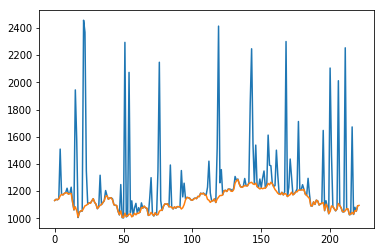

In [15]:
import keras.layers as kl
from keras.models import Model
from keras import regularizers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bokeh.plotting import output_file, figure, show


class NeuralNetwork:
    def __init__(self, input_shape, stock_or_return):
        self.input_shape = input_shape
        self.stock_or_return = stock_or_return

    def make_train_model(self):
        input_data = kl.Input(shape=(1, self.input_shape))
        lstm = kl.LSTM(5, input_shape=(1, self.input_shape), return_sequences=True, activity_regularizer=regularizers.l2(0.003),
                       recurrent_regularizer=regularizers.l2(0), dropout=0.2, recurrent_dropout=0.2)(input_data)
        perc = kl.Dense(5, activation="sigmoid", activity_regularizer=regularizers.l2(0.005))(lstm)
        lstm2 = kl.LSTM(2, activity_regularizer=regularizers.l2(0.01), recurrent_regularizer=regularizers.l2(0.001),
                        dropout=0.2, recurrent_dropout=0.2)(perc)
        out = kl.Dense(1, activation="sigmoid", activity_regularizer=regularizers.l2(0.001))(lstm2)

        model = Model(input_data, out)
        model.compile(optimizer="adam", loss="mean_squared_error", metrics=["mse"])

        # load data

        train = np.reshape(np.array(pd.read_csv("features/autoencoded_train_data_GOOGL.csv", index_col=0)),
                           (len(np.array(pd.read_csv("features/autoencoded_train_data_GOOGL.csv"))), 1, self.input_shape))
        train_y = np.array(pd.read_csv("features/autoencoded_train_y_GOOGL.csv", index_col=0))
        # train_stock = np.array(pd.read_csv("train_stock.csv"))

        # train model

        model.fit(train, train_y, epochs=2000)

        model.save("models/model_GOOGL.h5", overwrite=True, include_optimizer=True)

        test_x = np.reshape(np.array(pd.read_csv("features/autoencoded_test_data_GOOGL.csv", index_col=0)),
                            (len(np.array(pd.read_csv("features/autoencoded_test_data_GOOGL.csv"))), 1, self.input_shape))
        test_y = np.array(pd.read_csv("features/autoencoded_test_y_GOOGL.csv", index_col=0))
        # test_stock = np.array(pd.read_csv("test_stock.csv"))

        stock_data_test = np.array(pd.read_csv("stock_data_test_GOOGL.csv", index_col=0))

        print(model.evaluate(test_x, test_y))
        prediction_data = []
        stock_data = []
        for i in range(len(test_y)):
            prediction = (model.predict(np.reshape(test_x[i], (1, 1, self.input_shape))))
            prediction_data.append(np.reshape(prediction, (1,)))
            prediction_corrected = (prediction_data - np.mean(prediction_data))/np.std(prediction_data)
            stock_price = np.exp(np.reshape(prediction, (1,)))*stock_data_test[i]
            stock_data.append(stock_price[0])
        stock_data[:] = [i - (float(stock_data[0])-float(stock_data_test[0])) for i in stock_data]
        # stock_data = stock_data - stock_data[0]
        if self.stock_or_return:
            plt.plot(stock_data)
            plt.plot(stock_data_test)
            stock = pd.DataFrame(stock_data, index=None)
            stock.to_csv("sample_predictions/predicted_prices_GOOGL.csv")
            stock_test = pd.DataFrame(stock_data_test, index=None)
            stock_test.to_csv("sample_predictions/actual_prices_GOOGL.csv")
            # print(stock_data)
            plt.show()
        else:
            # plt.plot(prediction_corrected)
            plt.plot(prediction_data)
            # print(prediction_data)
            plt.plot(test_y)
            plt.show()


if __name__ == "__main__":
    model = NeuralNetwork(20, True)
model.make_train_model()

In [16]:
prediction_AAPL = pd.read_csv("sample_predictions/predicted_prices_GOOGL.csv", header=0, index_col=0)
actual_AAPL = pd.read_csv("sample_predictions/actual_prices_GOOGL.csv", header=0, index_col=0)

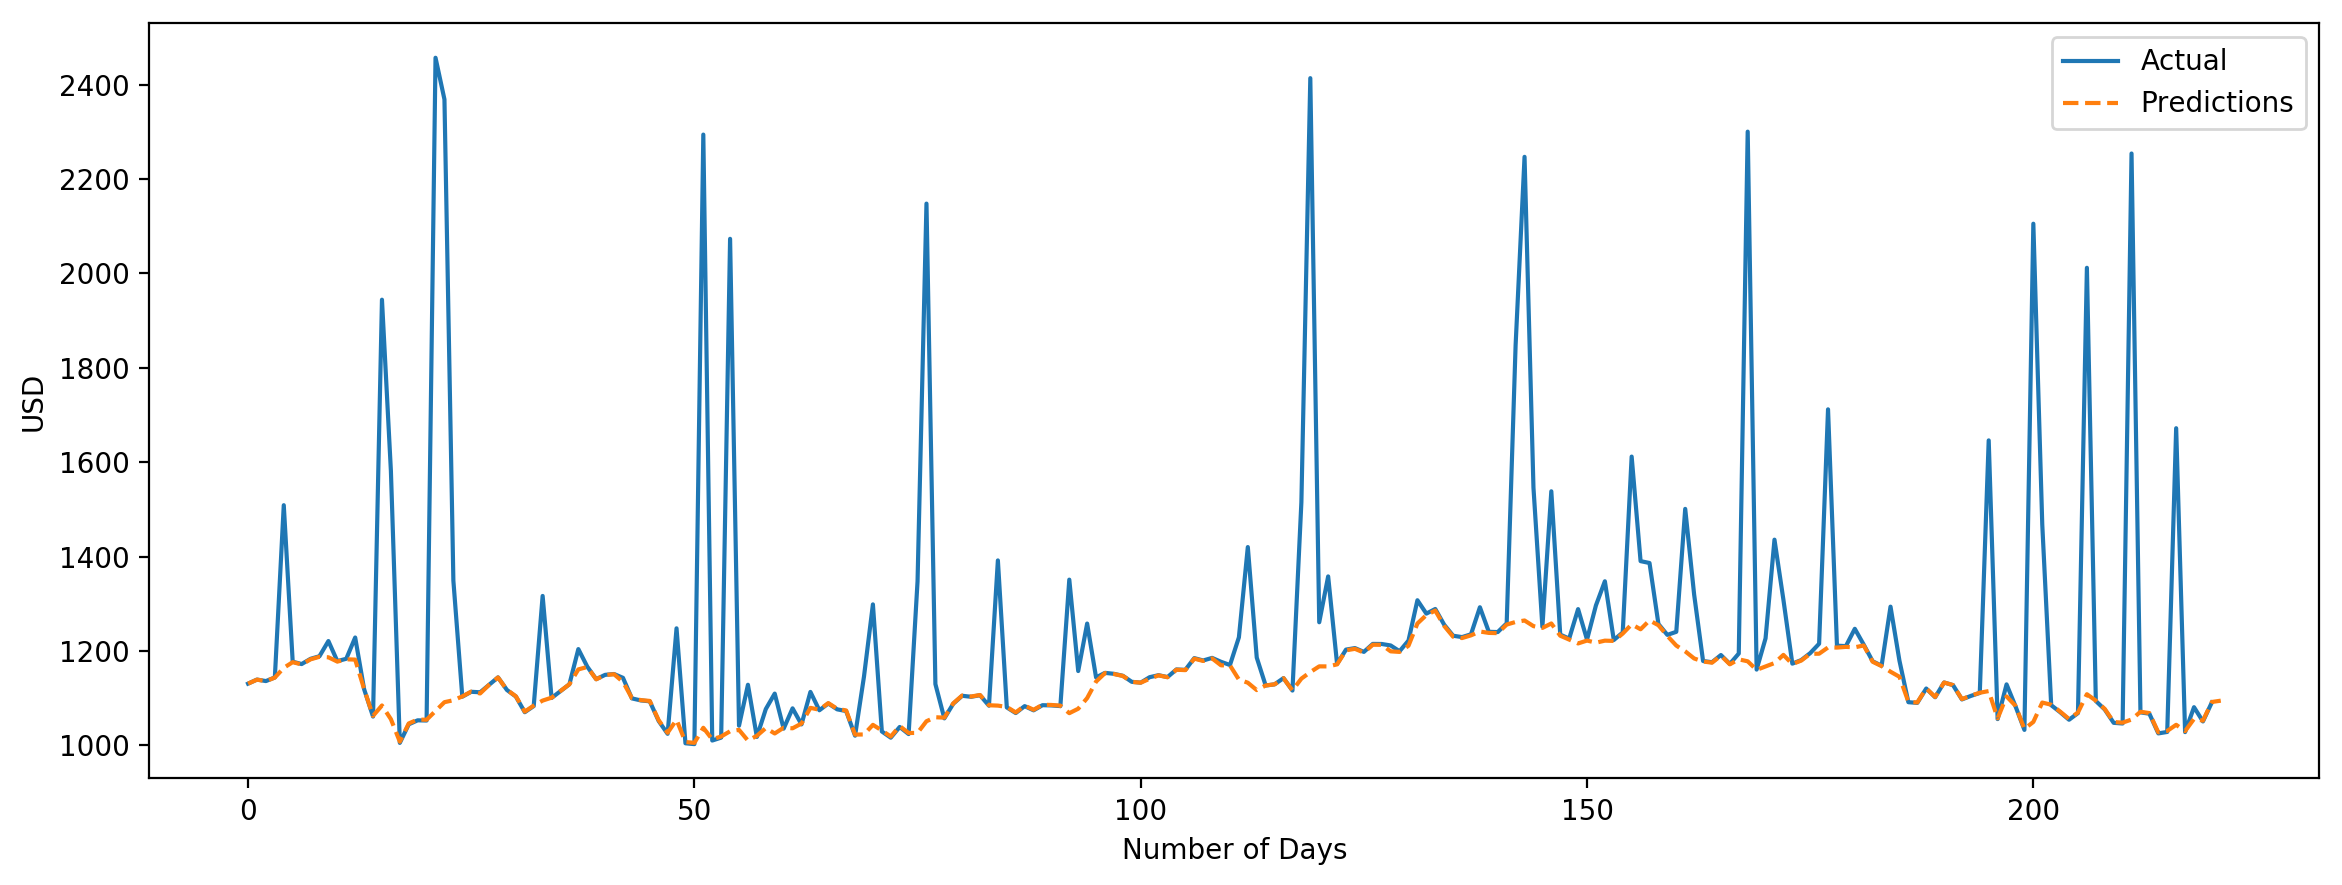

In [17]:
#plot
plt.figure(figsize=(14, 5), dpi=200)
plt.xlabel('Number of Days')
plt.ylabel('USD')
plt.plot(prediction_AAPL)
plt.plot(actual_AAPL, marker='', linestyle='dashed')
plt.legend(('Actual','Predictions'))
plt.show()

## The Above Trained Model shows better results than previously used modeling techniques as we can see from the output the plot shows the predicted values going more towards the true values